<h1>Capstone Project

<img src="https://images.pexels.com/photos/3448250/pexels-photo-3448250.jpeg?auto=compress&cs=tinysrgb&w=1260&h=750&dpr=2" height="350">

### Import Libraries

In [136]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import time

from sklearn import metrics
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler

import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px


### Load Data


In [137]:
# The reason you get this low_memory warning is because 
# guessing dtypes for each column is very memory demanding.

player_df = pd.read_csv('data/female/female_players_22.csv', low_memory=False)
player_df.head()

,sofifa_id,player_url,short_name,long_name,player_positions,overall,potential,value_eur,wage_eur,age,...,lcb,cb,rcb,rb,gk,player_face_url,club_logo_url,club_flag_url,nation_logo_url,nation_flag_url
0,227246,https://sofifa.com/player/227246/lucy-bronze/2...,L. Bronze,Lucia Roberta Tough Bronze,"RB, CM",92,92,NaN,NaN,29,...,87+3,87+3,87+3,88+3,21+3,https://cdn.sofifa.com/players/227/246/22_120.png,NaN,NaN,https://cdn.sofifa.com/teams/113002/60.png,https://cdn.sofifa.com/flags/gb-eng.png
1,227316,https://sofifa.com/player/227316/wendie-renard...,W. Renard,Wéndèleine Thérèse Renard,CB,92,92,NaN,NaN,30,...,90+2,90+2,90+2,80+3,20+3,https://cdn.sofifa.com/players/227/316/22_120.png,NaN,NaN,https://cdn.sofifa.com/teams/113003/60.png,https://cdn.sofifa.com/flags/fr.png
2,233746,https://sofifa.com/player/233746/vivianne-mied...,V. Miedema,Vivianne Miedema,ST,92,93,NaN,NaN,24,...,52+3,52+3,52+3,57+3,24+3,https://cdn.sofifa.com/players/233/746/22_120.png,NaN,NaN,https://cdn.sofifa.com/teams/113011/60.png,https://cdn.sofifa.com/flags/nl.png
3,227125,https://sofifa.com/player/227125/samantha-kerr...,S. Kerr,Samantha May Kerr,"ST, LW",91,91,NaN,NaN,27,...,56+3,56+3,56+3,60+3,20+3,https://cdn.sofifa.com/players/227/125/22_120.png,NaN,NaN,https://cdn.sofifa.com/teams/112998/60.png,https://cdn.sofifa.com/flags/au.png
4,226301,https://sofifa.com/player/226301/alex-morgan/2...,A. Morgan,Alexandra Morgan Carrasco,ST,90,90,NaN,NaN,31,...,56+3,56+3,56+3,62+3,19+3,https://cdn.sofifa.com/players/226/301/22_120.png,NaN,NaN,https://cdn.sofifa.com/teams/113009/60.png,https://cdn.sofifa.com/flags/us.png


### Shape

In [138]:
player_df.shape

(391, 110)

In [139]:
len(player_df['player_positions'].unique())

124

In [140]:
positions = [ 'ls','st','rs','lw','lf','cf','rf','rw','lam','cam','ram','lm','lcm','cm','rcm','rm','lwb','ldm','cdm','rdm','rwb','lb','lcb','cb','rcb','rb','gk']
len(positions)

27

<li>Originally 27 player positions have been shortlisted
<li>But there are 124 combinations of these positions in the dataset
<li> This is because certain players are versatile and can play in multiple positions




In [141]:
# list(player_df.dtypes)

### Check Nulls

In [142]:
player_df.isnull().sum()

sofifa_id             0
player_url            0
short_name            0
long_name             0
player_positions      0
                   ... 
player_face_url       0
club_logo_url       391
club_flag_url       391
nation_logo_url       0
nation_flag_url       0
Length: 110, dtype: int64

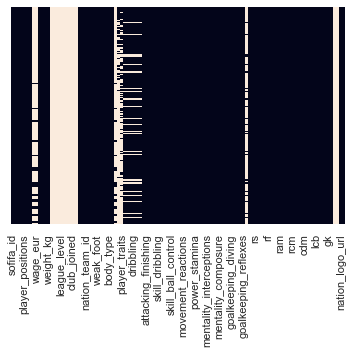

In [143]:
sns.heatmap(player_df.isnull(),yticklabels=False,cbar=False)
plt.show()

### Create a Data frame to show Cols and their null percentage

In [144]:
null_dict = (dict(player_df.isna().mean().round(4)*100))
null_df = pd.DataFrame.from_dict(null_dict, orient="index").reset_index()
null_df.columns = ['col', 'percentage']
null_df = null_df.sort_values('percentage',ascending=False)
null_df.head(20)

,col,percentage
21,club_contract_valid_until,100.00
13,club_team_id,100.00
20,club_joined,100.00
107,club_flag_url,100.00
106,club_logo_url,100.00
19,club_loaned_from,100.00
18,club_jersey_number,100.00
17,club_position,100.00
16,league_level,100.00
15,league_name,100.00


### Data Cleaning

In [145]:
cols_to_drop = ['nation_jersey_number','nation_logo_url','nation_position','nation_team_id','club_loaned_from','player_tags',
                'release_clause_eur','player_traits'
                ]

player_df.drop(columns=cols_to_drop,inplace=True)

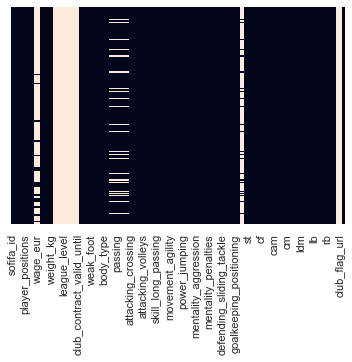

In [146]:
sns.heatmap(player_df.isnull(),yticklabels=False,cbar=False)
plt.show()

### Heatmap of abilities

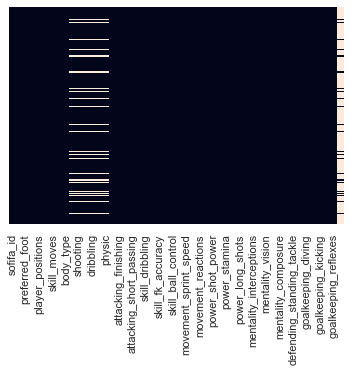

In [147]:
abilities =  ['sofifa_id',
              'short_name',
              'preferred_foot',
              'overall',
              'player_positions',
              'weak_foot',
              'skill_moves',
              'work_rate',
              'body_type',
              # 'player_traits',
              'pace',
              'shooting',
              'passing',
              'dribbling',
              'defending',
              'physic',
              'attacking_crossing',
              'attacking_finishing',
              'attacking_heading_accuracy',
              'attacking_short_passing',
              'attacking_volleys',
              'skill_dribbling',
              'skill_curve',
              'skill_fk_accuracy',
              'skill_long_passing',
              'skill_ball_control',
              'movement_acceleration',
              'movement_sprint_speed',
              'movement_agility',
              'movement_reactions',
              'movement_balance',
              'power_shot_power',
              'power_jumping',
              'power_stamina',
              'power_strength',
              'power_long_shots',
              'mentality_aggression',
              'mentality_interceptions',
              'mentality_positioning',
              'mentality_vision',
              'mentality_penalties',
              'mentality_composure',
              'defending_marking_awareness',
              'defending_standing_tackle',
              'defending_sliding_tackle',
              'goalkeeping_diving',
              'goalkeeping_handling',
              'goalkeeping_kicking',
              'goalkeeping_positioning',
              'goalkeeping_reflexes',
              'goalkeeping_speed']

abilities_df = player_df[abilities]

sns.heatmap(abilities_df.isnull(),yticklabels=False,cbar=False)
plt.show()

Sorted dataframe based on percentge of null values

In [148]:
skills_null_dict = (dict(abilities_df.isna().mean().round(4) * 100))
skills_null_df = pd.DataFrame.from_dict(skills_null_dict, orient="index").reset_index()
skills_null_df.columns = ['col', 'percentage']
skills_null_df = skills_null_df.sort_values('percentage',ascending=False)
skills_null_df.head(10)

,col,percentage
49,goalkeeping_speed,87.72
9,pace,12.28
13,defending,12.28
12,dribbling,12.28
11,passing,12.28
10,shooting,12.28
14,physic,12.28
43,defending_sliding_tackle,0.00
38,mentality_vision,0.00
30,power_shot_power,0.00


In [149]:
# len(player_df['player_traits'].unique())

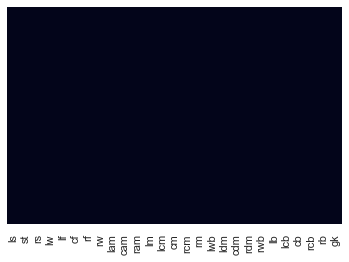

In [150]:
player_pos_df = player_df[positions]

sns.heatmap(player_pos_df.isnull(),yticklabels=False,cbar=False)
plt.show()


In [151]:
def clean_data(df):


    null_cols = ['pace','shooting','passing','dribbling','defending','physic']

    # iterate through each null column
    for col in null_cols:

        df[col].fillna(0,inplace=True)

    return df

    

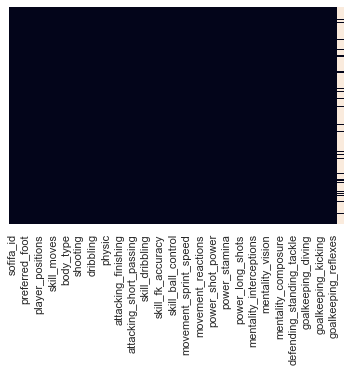

In [152]:
abilities_df_cleaned =  clean_data(abilities_df.copy())
# save dataframe to directory
abilities_df_cleaned.to_csv('data/female_player_abilities.csv')
sns.heatmap(abilities_df_cleaned.isnull(),yticklabels=False,cbar=False)

plt.show()

In [153]:
abilities_df_cleaned.head(20)

,sofifa_id,short_name,preferred_foot,overall,player_positions,weak_foot,skill_moves,work_rate,body_type,pace,...,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
0,227246,L. Bronze,Right,92,"RB, CM",3,3,High/High,Normal (170-185),86.0,...,80,90,88,89,10,14,16,8,15,NaN
1,227316,W. Renard,Right,92,CB,2,2,High/Medium,Lean (185+),68.0,...,80,90,93,91,7,14,17,11,15,NaN
2,233746,V. Miedema,Right,92,ST,4,4,High/Low,Normal (170-185),81.0,...,91,22,30,23,14,16,17,14,17,NaN
3,227125,S. Kerr,Right,91,"ST, LW",4,4,High/Medium,Normal (170-),87.0,...,92,36,38,23,7,12,8,16,13,NaN
4,226301,A. Morgan,Left,90,ST,4,4,High/Low,Unique,86.0,...,91,34,29,27,11,11,10,10,11,NaN
5,226308,D. Marozsán,Right,90,"CAM, LM, CM",4,5,High/Medium,Normal (170-185),82.0,...,89,51,46,53,8,10,15,9,12,NaN
6,226328,M. Rapinoe,Right,90,"LW, LM",4,4,High/Low,Lean (170-),71.0,...,90,46,46,48,15,12,14,14,11,NaN
7,226330,T. Heath,Right,90,"RW, CAM, LW",5,5,Medium/High,Lean (170-),77.0,...,92,31,38,39,12,7,7,16,8,NaN
8,227102,C. Hansen,Right,90,"RM, CAM, ST",4,4,High/Medium,Lean (170-185),87.0,...,84,45,50,46,17,11,15,13,9,NaN
9,227318,A. Henry,Right,90,"CDM, CM",3,4,High/High,Normal (170-185),74.0,...,83,93,90,84,11,13,15,14,7,NaN


In [157]:
def plot_violin_plot(df,x_col='defending',y_col='work_rate'):

       unique_cols = list(df[y_col].unique())

       fig = go.Figure()

       for rate in unique_cols:
              fig.add_trace(go.Violin(x=abilities_df_cleaned[y_col][abilities_df_cleaned[y_col] == rate],
                                      y=abilities_df_cleaned[x_col][abilities_df_cleaned[y_col] == rate],
                                      name=rate,
                                      box_visible=True,
                                      meanline_visible=True))


       title = x_col.replace('_'," ").capitalize()+" vs "+ y_col.replace('_'," ").capitalize()

       fig.update_layout(title=title,
                     xaxis_title=y_col,
                     yaxis_title=x_col,
                     legend_title=y_col.replace('_'," ").capitalize(),
                     font=dict(
                     family="Courier New, monospace",
                     size=12,
                     color="black"
       ))
       fig.show()

Dribbing vs Body Type

In [158]:
plot_violin_plot(abilities_df_cleaned,x_col='dribbling',y_col='body_type')

Defending vs Body Type

In [159]:
plot_violin_plot(abilities_df_cleaned,x_col='defending',y_col='body_type')

In [160]:
def plot_dist(df, col):
    
    plt.title('Distribution of ' + col)
    sns.kdeplot(df[col],color = "b")
    plt.show()


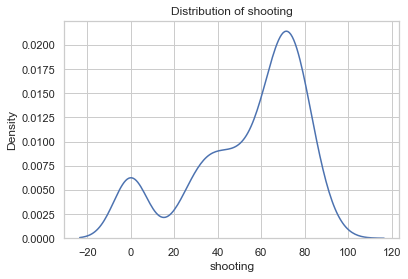

In [161]:
plot_dist(abilities_df_cleaned, col='shooting')

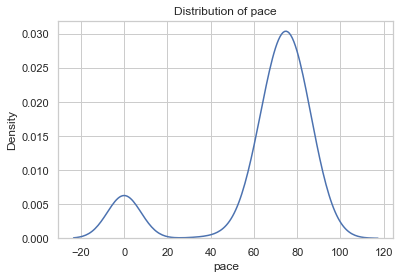

In [162]:
plot_dist(abilities_df_cleaned, col='pace')